In [1]:
# Imports
import sys
import logging
import os
from collections import OrderedDict
import torch
import shutil
from torch.nn.parallel import DistributedDataParallel
from sklearn.model_selection import KFold
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage
import cv2
import pickle
from detectron2.structures import BoxMode
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2 import model_zoo
import numpy as np

In [2]:
# Custom HubMap Dataset
class HubMapDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, 'all_dataset1_imgs')
        self.annotation_dir = os.path.join(data_dir, 'all_dataset1_annotations')
        self.image_file_list = os.listdir(self.image_dir)
        self.annotation_file_list = os.listdir(self.annotation_dir)
        
    def __len__(self):
        return len(self.image_file_list)
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_file_list[idx])
        annotation_path = os.path.join(self.annotation_dir, self.annotation_file_list[idx])
        
        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        
        record = {
            'file_name': image_path,
            'image_id': idx,
            'height': height,
            'width': width,
        }
        
        with open(annotation_path, 'rb') as f:
            orig_annots = pickle.load(f)
        
        objs = []
        for orig_annot in orig_annots:
            orig_annot['bbox_mode'] = BoxMode.XYWH_ABS
            objs.append(orig_annot)
            
        record['annotations'] = objs
        
        return record

In [3]:
class ValidationDataset:
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        idx = self.indices[idx]
        return self.dataset[idx]

In [4]:
# Function to register a dataset
def register_custom_dataset(dataset_name, data_dir):
    DatasetCatalog.register(dataset_name, lambda: HubMapDataset(data_dir))
    MetadataCatalog.get(dataset_name).set(thing_classes=['blood_vessel'], evaluator_type="coco")

In [5]:
class CustomArguments:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [6]:
# arguments
config_file = '/home/ec2-user/hubmap-hacking-the-human-vasculature/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
train_dataset_name = 'hubmap-dataset-1'
train_dir = '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files'
num_machines = 1
num_gpus = 1
machine_rank = 0
port = 2**15 + 2**14 + hash(os.getuid() if sys.platform != "win32" else 1) % 2**14
dist_url = "tcp://127.0.0.1:{}".format(port)
opts = []
argument_dict = {'config_file':config_file, 'train_dataset_name': train_dataset_name, 'train_dir': train_dir, 'num_machines':num_machines, 'num_gpus':num_gpus, 'machine_rank': machine_rank, 'dist_url':dist_url, 'opts': opts}
args = CustomArguments(**argument_dict)

In [7]:
# Setup the config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = (train_dataset_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 30000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MIN_SIZE_TRAIN = (256,350,480,512)  # Minimum input image size during training
cfg.INPUT.MAX_SIZE_TRAIN = 512     # Maximum input image size during training
cfg.INPUT.MIN_SIZE_TEST = 512      # Minimum input image size during testing
cfg.INPUT.MAX_SIZE_TEST = 512      # Maximum input image size during testing
cfg.MODEL.DEVICE = 'cpu'
print(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MAX_SIZE_TEST)

(256, 350, 480, 512) 512 512 512


In [8]:
# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_transforms = [
    T.RandomRotation([-90,90], expand=True),
    T.RandomFlip(horizontal=True, vertical=False),
    T.RandomFlip(horizontal=False, vertical=True),
    T.RandomBrightness(0.8, 1.2),
    T.RandomContrast(0.8, 1.2),
    T.RandomSaturation(0.8,1.2)
]
# data_loader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=data_transforms))

In [9]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

In [10]:
register_custom_dataset(train_dataset_name, train_dir)

In [ ]:
# model = build_model(cfg)
# model.train()

In [ ]:
# # for i in range(num_folds):
# if os.path.exists(os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-val-fold-0')):
#     shutil.rmtree(os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-val-fold-0'))
# hubmap_dataset = DatasetCatalog.get(train_dataset_name)
# DatasetCatalog.register(f'{train_dataset_name}-val-fold-0', lambda: ValidationDataset(hubmap_dataset, [1,2]))
# MetadataCatalog.get(f'{train_dataset_name}-val-fold-0').set(thing_classes=['blood_vessel'], evaluator_type="coco")

In [ ]:
# evaluator = get_evaluator(
#         cfg, f'{train_dataset_name}-val-fold-0', os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-val-fold-0')
#     )
# data_loader = build_detection_test_loader(cfg, dataset_name=f'{train_dataset_name}-val-fold-0')

In [ ]:
# metrics = inference_on_dataset(model, data_loader, evaluator)

In [ ]:
import time
# Define the number of folds for cross-validation
register_custom_dataset(train_dataset_name, train_dir)
hubmap_dataset = DatasetCatalog.get(train_dataset_name)
num_folds = 5
# Initialize the KFold cross-validator
kf = KFold(n_splits=num_folds)

max_iter = cfg.SOLVER.MAX_ITER
writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

output_dir = os.path.join(cfg.OUTPUT_DIR, "inference")

for i in range(num_folds):
    if os.path.exists(f'{output_dir}/model_stats_detectron_dataset1_fold_{i}.txt'):
        os.remove(f'{output_dir}/model_stats_detectron_dataset1_fold_{i}.txt')

if os.path.exists(os.path.join(cfg.OUTPUT_DIR, "inference", train_dataset_name)):
    shutil.rmtree(os.path.join(cfg.OUTPUT_DIR, "inference", train_dataset_name))
for i in range(num_folds):
    if os.path.exists(os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-val-fold-{i}')):
        shutil.rmtree(os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-val-fold-{i}'))
    if os.path.exists(os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-train-fold-{i}')):
        shutil.rmtree(os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-train-fold-{i}'))

# Loop over the folds
for fold, (train_indices, val_indices) in enumerate(kf.split(hubmap_dataset)):
    train_indices = train_indices.tolist()
    val_indices = val_indices.tolist()
    # Create the training and validation data loaders for the current fold
    train_dataset = [hubmap_dataset[i] for i in train_indices]
    DatasetCatalog.register(f'{train_dataset_name}-train-fold-{fold}', lambda: ValidationDataset(hubmap_dataset, train_indices))
    MetadataCatalog.get(f'{train_dataset_name}-train-fold-{fold}').set(thing_classes=['blood_vessel'], evaluator_type="coco")
    DatasetCatalog.register(f'{train_dataset_name}-val-fold-{fold}', lambda: ValidationDataset(hubmap_dataset, val_indices))
    MetadataCatalog.get(f'{train_dataset_name}-val-fold-{fold}').set(thing_classes=['blood_vessel'], evaluator_type="coco")
#     train_data_loader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=data_transforms), dataset=train_dataset)
    train_data_loader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True), dataset=train_dataset)
    train_test_data_loader =  build_detection_test_loader(cfg, f'{train_dataset_name}-train-fold-{fold}')
    val_data_loader = build_detection_test_loader(cfg, f'{train_dataset_name}-val-fold-{fold}')
    evaluator = get_evaluator(
        cfg, f'{train_dataset_name}-val-fold-{fold}', os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-val-fold-{fold}')
    )
    train_evaluator = get_evaluator(
        cfg, f'{train_dataset_name}-train-fold-{fold}', os.path.join(cfg.OUTPUT_DIR, "inference", f'{train_dataset_name}-train-fold-{fold}')
    )
    model = build_model(cfg)
    model.train()
    resume = False
    optimizer = build_optimizer(cfg, model)
    scheduler = build_lr_scheduler(cfg, optimizer)
    checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
    start_iter = (
        checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
    )
    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
    )
    num_epochs = max_iter // len(train_dataset)
    iterations_per_epoch = len(train_dataset) // cfg.SOLVER.IMS_PER_BATCH
    epoch = 0
    max_ap_50 = 0
    loss_stats = {'total_loss': [], 'loss_cls': [], 'loss_box_reg': [], 'loss_mask': [], 'loss_rpn_cls': [], 'loss_rpn_loc': []}
    with open(f'{output_dir}/model_stats_detectron_dataset1_fold_{fold}.txt', 'a') as f:
        f.write(f'Epoch info is - num_epochs: {num_epochs}, max_iter: {max_iter}, train_dataset_len: {len(train_dataset)}, iterations_per_epoch: {iterations_per_epoch}\n')
    with EventStorage(start_iter) as storage:
        epoch_start_time = time.time()
        for data, iteration in zip(train_data_loader, range(start_iter, max_iter)):
            storage.iter = iteration

            loss_dict = model(data)
            for loss_key in loss_dict:
                if loss_key in loss_stats:
                    loss_stats[loss_key].append(loss_dict[loss_key].item())
            losses = sum(loss_dict.values())
            loss_stats['total_loss'] = losses.item()
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            scheduler.step()

            if iteration - start_iter > 5 and (
                (iteration + 1) % 20 == 0 or iteration == max_iter - 1
            ):
                for writer in writers:
                    writer.write()
            periodic_checkpointer.step(iteration)
        
            if (iteration+1) % iterations_per_epoch == 0:
                train_metrics = inference_on_dataset(model, train_test_data_loader, evaluator)
                metrics = inference_on_dataset(model, val_data_loader, evaluator)
                print('===========')
                print(train_metrics)
                print(metrics)
                print('===========')
                metrics_str = ''
                for task, task_metrics in metrics.items():
                    task_str = f'{task}: '
                    for metric, value in task_metrics.items():
                        task_str += f'{metric}={value:.4f}, '
                    metrics_str += task_str.rstrip(', ') + '\n'
                for task, task_metrics in train_metrics.items():
                    task_str = f'Training {task}: '
                    for metric, value in task_metrics.items():
                        task_str += f'{metric}={value:.4f}, '
                    metrics_str += task_str.rstrip(', ') + '\n'
                metrics_str = f'Epoch {epoch}, Iteration: {iteration}, time_taken: {float(time.time()-epoch_start_time)/60} minutes --> {metrics_str}'
                loss_str = ''
                for loss_key in loss_stats.keys():
                    loss_str += f'{loss_key} - {np.mean(loss_stats[loss_key])}, '
                    loss_stats[loss_key] = []
                if 'segm' in metrics and metrics['segm']['AP50'] > max_ap_50:
                    max_ap_50 = metrics['segm']['AP50']
                    torch.save(model.state_dict(), f'{output_dir}/best_model_fold_{fold}.pth')
                    with open(f'{output_dir}/best_model_detectron_dataset1_fold_{fold}.txt', 'w') as f:
                        f.write(f'{metrics_str}\n{loss_str}\n')
                with open(f'{output_dir}/model_stats_detectron_dataset1_fold_{fold}.txt', 'a') as f:
                    f.write(f'{metrics_str}\n{loss_str}\n')
                epoch_start_time = time.time()
                epoch += 1

In [11]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

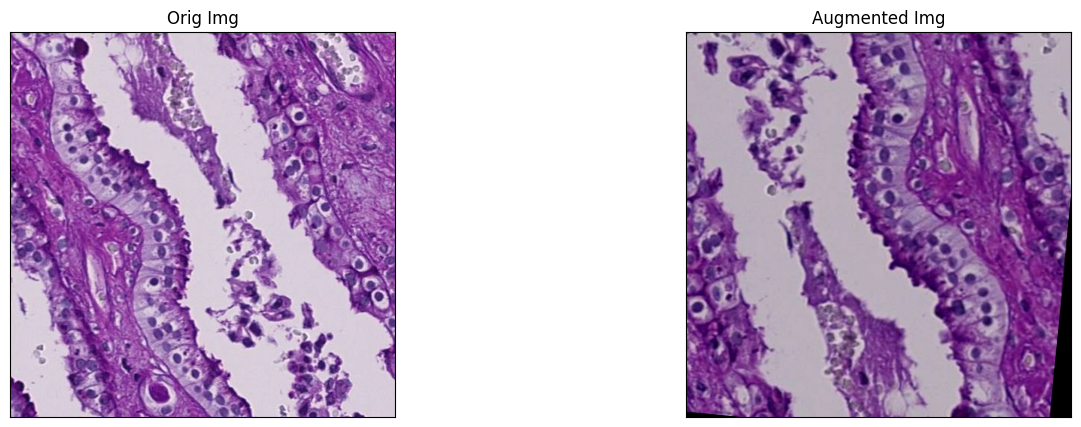

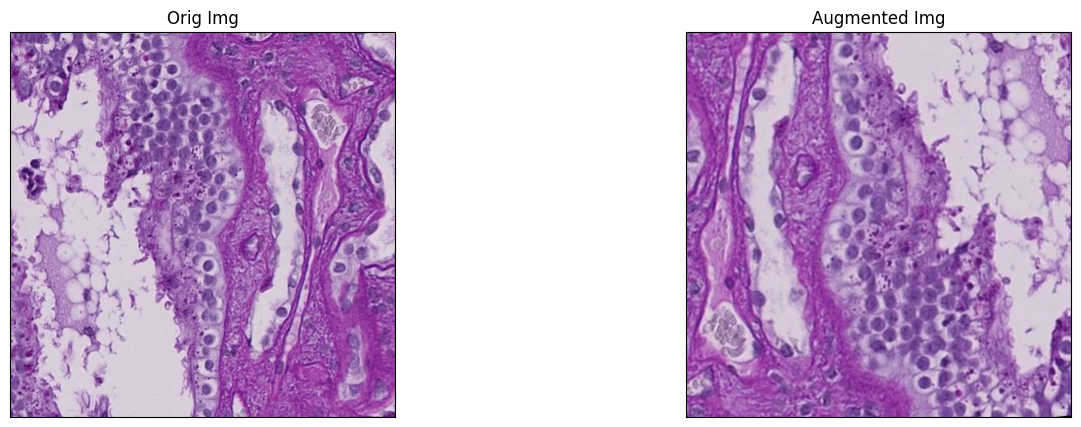

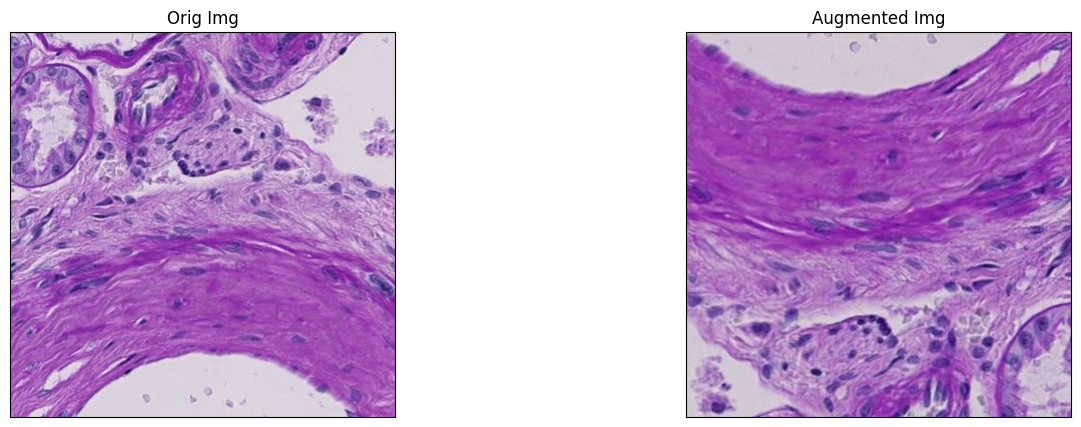

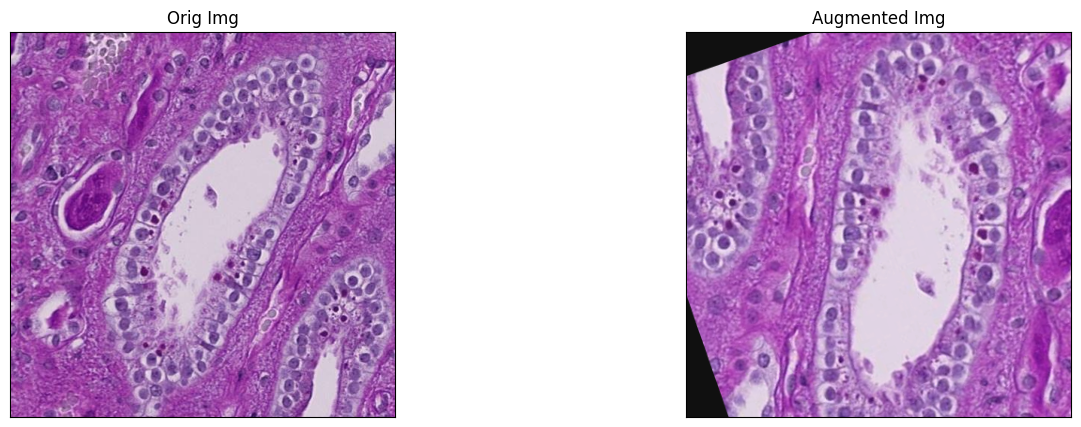

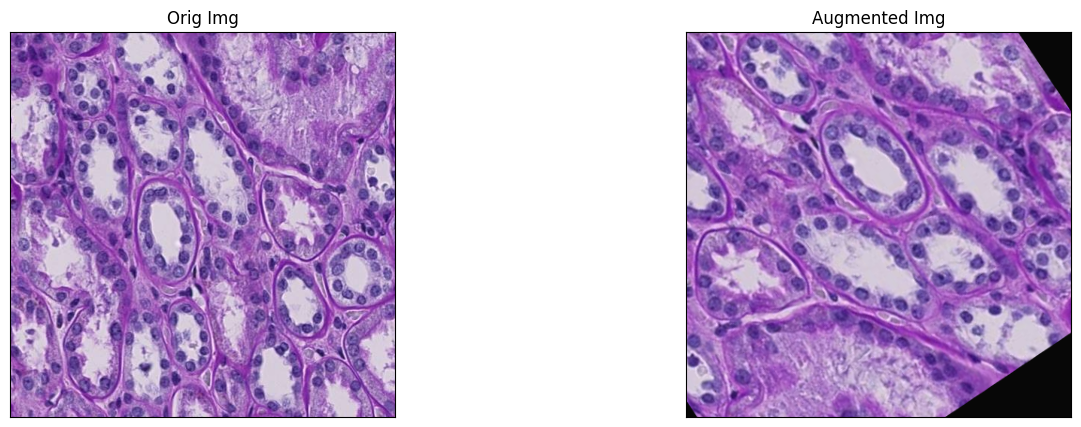

In [21]:
import matplotlib.pyplot as plt
prob = 1.0
data_transforms = [
    T.RandomApply(T.RandomRotation([-45,45], expand=False), prob=prob),
    T.RandomFlip(horizontal=True, vertical=False, prob=prob),
    T.RandomFlip(horizontal=False, vertical=True, prob=prob),
    T.RandomApply(T.RandomBrightness(0.8, 1.2), prob=prob),
    T.RandomApply(T.RandomContrast(0.8, 1.2), prob=prob),
    T.RandomApply(T.RandomSaturation(0.8,1.2), prob=prob),
    T.RandomApply(T.RandomCrop('relative', (0.8, 0.8)), prob=prob)
]
data_loader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=data_transforms))
for data, iteration in zip(data_loader, range(0, 5)):
    image_dict = dict()
    file_path = data[0]['file_name']
    orig_img = cv2.imread(file_path)
#     orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    augmented_img = data[0]['image'].transpose(1,0).transpose(1,2)
    image_dict['orig_img'] = orig_img
    image_dict['augmented_img'] = augmented_img
    visualize(**image_dict)

In [ ]:
from detectron2.engine import DefaultPredictor
cfg = get_cfg()
cfg.merge_from_file(args.config_file)
cfg.merge_from_list(args.opts)
cfg.MODEL.WEIGHTS = "./output/model_0000199.pth"
cfg.freeze()
default_setup(
    cfg, args
)
predictor = DefaultPredictor(cfg)

In [ ]:
model = build_model(cfg)

In [ ]:
model

In [ ]:
for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)

In [ ]:
for data, iteration in zip(data_loader, range(0, 5)):
    print(data[0])

In [ ]:
if "hubmap-dataset-1" not in MetadataCatalog.list():
    register_custom_dataset('hubmap-dataset-1', '/home/ec2-user/hubmap-hacking-the-human-vasculature/dataset1_files')
model = predictor.model
results = OrderedDict()
for dataset_name in cfg.DATASETS.TEST:
    print(dataset_name)
    data_loader = build_detection_test_loader(cfg, dataset_name)
    evaluator = get_evaluator(
        cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    results_i = inference_on_dataset(model, data_loader, evaluator)
    results[dataset_name] = results_i
    if comm.is_main_process():
        print_csv_format(results_i)
if len(results) == 1:
    results = list(results.values())[0]

In [ ]:
results[]